# Installation der requirements
!pip install pygraphviz
!pip install pandas
!pip install pyarrow
!pip install seaborn
!pip install scikit-learn
'pip install tensorflow

In [36]:
# Import der Libraries
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import pygraphviz as pgv
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
# Laden des Datensets
df = pd.read_csv('20210303_Showcase+AKAD_Palettenumlauf+Rohbau_final.csv', sep=';')
df.head()

,Timestamp,Area,HMI_MZEV_IW,PLCName,FGName_caller,D_sentMZEV,FGName_other,HMI_MZEV_DT,HMI_MZEV_EW,Connecting_PLC,Shop,Connecting_Timestamp,V_counterMZEV,KNR_filter,PLCName_filter,Palettennummer_filter,Day,Day_Case
0,2020-11-30 00:01:02.000,Montage BAU 2 1.OG,42619965,RS71SPS1,020DGT001,True,FGDB_000XTT001@JOB_DATA_110_2,NaN-NaN-NaNTNaN:NaN:NaN.NaN+0NaN:00,200075,UB75SPS2,Montage,27.11.2020 09:48,8242,42619965,RS71SPS1,200075,30.11.2020,30.11.2020
1,2020-11-30 00:01:08.000,Montage BAU 2 1.OG,42620034,FS72SPS2,050DGT001,True,FGDB_000XTT001@JOB_DATA_110_2,NaN-NaN-NaNTNaN:NaN:NaN.NaN+0NaN:00,200465,UB75SPS2,Montage,27.11.2020 10:17,8249,42620034,FS72SPS2,200465,30.11.2020,30.11.2020
2,2020-11-30 00:01:27.000,Montage BAU 2 1.OG,42620166,FS71SPS3,100DGT001,True,FGDB_000XTT001@JOB_DATA_110_2,NaN-NaN-NaNTNaN:NaN:NaN.NaN+0NaN:00,201430,UB75SPS2,Montage,27.11.2020 11:53,8263,42620166,FS71SPS3,201430,30.11.2020,30.11.2020
3,2020-11-30 00:01:31.000,Montage BAU 3 UG,42619588,F722SPS1,020DGT021,True,FGDB_000XTT001@JOB_DATA_110_2,NaN-NaN-NaNTNaN:NaN:NaN.NaN+0NaN:00,200060,UB75SPS2,Montage,27.11.2020 05:57,8206,42619588,F722SPS1,NaN,30.11.2020,30.11.2020
4,2020-11-30 00:01:38.000,BAU 5,42598885,MA72SPS2,050DGT001,True,FGDB_000XTT001@JOB_DATA_110_2,NaN-NaN-NaNTNaN:NaN:NaN.NaN+0NaN:00,201293,UB75SPS2,Montage,16.11.2020 15:47,6887,42598885,MA72SPS2,201293,30.11.2020,30.11.2020


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59054 entries, 0 to 59053
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Timestamp              59054 non-null  object
 1   Area                   59054 non-null  object
 2   HMI_MZEV_IW            59054 non-null  int64 
 3   PLCName                59054 non-null  object
 4   FGName_caller          59054 non-null  object
 5   D_sentMZEV             59054 non-null  bool  
 6   FGName_other           59054 non-null  object
 7   HMI_MZEV_DT            59054 non-null  object
 8   HMI_MZEV_EW            59054 non-null  object
 9   Connecting_PLC         59054 non-null  object
 10  Shop                   59054 non-null  object
 11  Connecting_Timestamp   59054 non-null  object
 12  V_counterMZEV          59054 non-null  int64 
 13  KNR_filter             59054 non-null  int64 
 14  PLCName_filter         59054 non-null  object
 15  Palettennummer_filt

In [39]:
# Auswahl und Umbennenen der Spalten
df = df[['Timestamp', 'Area', 'PLCName', 'HMI_MZEV_EW']].rename(columns={'Timestamp': 'Zeitpunkt', 'PLCName': 'Maschine', 'HMI_MZEV_EW': 'Palette'})
df.head()

,Zeitpunkt,Area,Maschine,Palette
0,2020-11-30 00:01:02.000,Montage BAU 2 1.OG,RS71SPS1,200075
1,2020-11-30 00:01:08.000,Montage BAU 2 1.OG,FS72SPS2,200465
2,2020-11-30 00:01:27.000,Montage BAU 2 1.OG,FS71SPS3,201430
3,2020-11-30 00:01:31.000,Montage BAU 3 UG,F722SPS1,200060
4,2020-11-30 00:01:38.000,BAU 5,MA72SPS2,201293


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59054 entries, 0 to 59053
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Zeitpunkt  59054 non-null  object
 1   Area       59054 non-null  object
 2   Maschine   59054 non-null  object
 3   Palette    59054 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [40]:
# Sortierung nach Palette, dann Zeitpunkt um den Workflow einer Palette nachvollziehen zu können.
dfFlow = df.sort_values(by=['Palette', 'Zeitpunkt'], ascending=True)
dfFlow.head()

,Zeitpunkt,Area,Maschine,Palette
172,2020-11-30 03:02:46.000,Montage BAU 2 1.OG,AS72SPS1,#WERT!
250,2020-11-30 03:56:36.000,Montage BAU 2 1.OG,FS71SPS1,#WERT!
258,2020-11-30 04:02:01.000,Montage BAU 2 1.OG,FS71SPS2,#WERT!
290,2020-11-30 04:39:11.000,Montage BAU 2 1.OG,FS71SPS3,#WERT!
596,2020-11-30 09:17:19.000,Montage BAU 3 UG,F721SPS1,#WERT!


In [41]:
# Anzeige aller eindeutigen Paletten-Werte
paletten = dfFlow['Palette'].unique()
paletten

array(['#WERT!', '0', '105600', '200005', '200018', '200022', '200035',
       '200039', '200047', '200051', '200060', '200064', '200068',
       '200075', '200084', '200088', '200096', '200100', '200113',
       '200117', '200121', '200130', '200134', '200138', '200142',
       '200146', '200155', '200159', '200163', '200167', '200179',
       '200183', '200187', '200191', '200195', '200208', '200212',
       '200216', '200220', '200229', '200233', '200237', '200241',
       '200250', '200254', '200258', '200266', '200275', '200278',
       '200282', '200286', '200290', '200299', '200303', '200311',
       '200315', '200324', '200328', '200332', '200336', '200345',
       '200349', '200353', '200357', '200361', '200370', '200374',
       '200377', '200381', '200385', '200394', '200398', '200406',
       '200419', '200423', '200427', '200431', '200440', '200444',
       '200448', '200452', '200456', '200465', '200469', '200473',
       '200476', '200480', '200489', '200493', '200497', 

In [42]:
maschinen = dfFlow['Maschine'].unique()
maschinen

array(['AS72SPS1', 'FS71SPS1', 'FS71SPS2', 'FS71SPS3', 'F721SPS1',
       'RS71SPS2', 'F722SPS1', 'AS73SPS1', 'F723SPS1', 'FS73SPS1',
       'RS73SPS3', 'RS74SPS2', 'RS75SPS2', 'FS74SPS1', 'FS74SPS2',
       'VH71SPS1', 'F730SPS1', 'MA71SPS1', 'MA71SPS2', 'MA71SPS3',
       'MA71SPS4', 'F731SPS1', 'MA72SPS1', 'MA72SPS2', 'MA72SPS3',
       'MA72SPS4', 'F733SPS1', 'F740SPS1', 'F710SPS1', 'AS71SPS1',
       'F720SPS1', 'FS72SPS1', 'FS72SPS2', 'FS72SPS3', 'RS71SPS1',
       'RS72SPS1', 'AS74SPS1', 'FS73SPS2', 'F724SPS1', 'RS73SPS1',
       'RS73SPS2', 'F725SPS1', 'RS74SPS1', 'RS74SPS3', 'RS75SPS1',
       'F726SPS1', 'UB75SPS2', 'AS75SPS1', 'PM71SPS1'], dtype=object)

In [43]:
# Die Werte #WERT! und 0 sollten entfernt werden für eine bessere Datenqualität:
dfFlow.drop(dfFlow.loc[(dfFlow['Palette'] == '#WERT!') | (dfFlow['Palette'] == '0')].index, inplace=True)

# Reset des Index für eine klare Sortierung > Für spätere Iterationen über die Liste wichtig.
dfFlow = dfFlow.reset_index(drop=True)
dfFlow.info()
# Es verbleiben 58656 Datesätze

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58656 entries, 0 to 58655
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Zeitpunkt  58656 non-null  object
 1   Area       58656 non-null  object
 2   Maschine   58656 non-null  object
 3   Palette    58656 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [8]:
dfFlow.head()

,Zeitpunkt,Area,Maschine,Palette
0,2020-12-01 05:24:41.000,Montage BAU 2,UB75SPS2,105600
1,2020-12-01 06:56:44.000,Montage BAU 3 UG,F710SPS1,105600
2,2020-12-01 07:13:10.000,Montage BAU 2 1.OG,AS71SPS1,105600
3,2020-12-01 07:18:14.000,Montage BAU 2 1.OG,AS72SPS1,105600
4,2020-12-01 07:32:51.000,Montage BAU 3 UG,F720SPS1,105600


In [44]:
# Wir gehen davon aus, dass eine Palette von einer Maschine zur nächsten transportiert wird. 
# Somit ist der Weg von Maschine X zu Maschine Y wichtig. 
# Das Dataframe sollte sinnvollerweise um die Herkunft der Palette ergänzt werden, zudem ist die Verweildauer de Palette an Maschine X
# ebenfalls von Relevanz um Bottlenecks ermitteln zu können

dfFlow['Herkunft'] = None
dfFlow['Verweildauer'] = 0.0
dfFlow['Area_Wechsel'] = False

for index in range(1, len(dfFlow)):
    act = dfFlow.loc[index]
    herk = dfFlow.loc[index - 1]
    if act['Palette'] == herk['Palette']:
        dfFlow.loc[index, 'Herkunft'] = herk['Maschine']
        dfFlow.loc[index, 'Verweildauer'] = (pd.to_datetime(act['Zeitpunkt']) - pd.to_datetime(herk['Zeitpunkt'])).total_seconds() / 60
        if herk['Area'] != act['Area']:
            dfFlow.loc[index, 'Area_Wechsel'] = True

In [45]:
# Einige Destinationen sind nun Null, wie erwartet.
dfFlow[dfFlow['Palette'] == '200075']

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel
1904,2020-11-30 00:01:02.000,Montage BAU 2 1.OG,RS71SPS1,200075,None,0.000000,False
1905,2020-11-30 01:41:29.000,Montage BAU 2 1.OG,RS72SPS1,200075,RS71SPS1,100.450000,False
1906,2020-11-30 02:35:50.000,Montage BAU 3 UG,F722SPS1,200075,RS72SPS1,54.350000,True
1907,2020-11-30 03:18:42.000,Montage BAU 2 1.OG,AS74SPS1,200075,F722SPS1,42.866667,True
1908,2020-11-30 04:35:11.000,BAU 2 2.OG,FS73SPS1,200075,AS74SPS1,76.483333,True
...,...,...,...,...,...,...,...
2100,2020-12-03 15:08:49.000,BAU 5,MA72SPS2,200075,MA72SPS1,4.183333,False
2101,2020-12-03 15:11:41.000,BAU 5,MA72SPS3,200075,MA72SPS2,2.866667,False
2102,2020-12-03 15:13:03.000,BAU 5,MA72SPS4,200075,MA72SPS3,1.366667,False
2103,2020-12-03 15:31:37.000,Montage BAU 3 UG,F733SPS1,200075,MA72SPS4,18.566667,True


In [46]:
# Nullwerte entfernen
dfCleaned = dfFlow[dfFlow['Verweildauer'] > 0]
dfCleaned

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel
1,2020-12-01 06:56:44.000,Montage BAU 3 UG,F710SPS1,105600,UB75SPS2,92.050000,True
2,2020-12-01 07:13:10.000,Montage BAU 2 1.OG,AS71SPS1,105600,F710SPS1,16.433333,True
3,2020-12-01 07:18:14.000,Montage BAU 2 1.OG,AS72SPS1,105600,AS71SPS1,5.066667,False
4,2020-12-01 07:32:51.000,Montage BAU 3 UG,F720SPS1,105600,AS72SPS1,14.616667,True
5,2020-12-01 07:35:05.000,Montage BAU 2 1.OG,FS71SPS1,105600,F720SPS1,2.233333,True
...,...,...,...,...,...,...,...
58651,2020-12-03 20:56:02.000,BAU 5,MA72SPS2,299038,MA72SPS1,4.283333,False
58652,2020-12-03 20:59:45.000,BAU 5,MA72SPS3,299038,MA72SPS2,3.716667,False
58653,2020-12-03 21:01:14.000,BAU 5,MA72SPS4,299038,MA72SPS3,1.483333,False
58654,2020-12-03 21:15:49.000,Montage BAU 3 UG,F733SPS1,299038,MA72SPS4,14.583333,True


In [47]:
dfCleaned['Area'].unique()

array(['Montage BAU 3 UG', 'Montage BAU 2 1.OG', 'BAU 2 2.OG', 'BAU 4 QM',
       'BAU 5', 'Montage BAU 2'], dtype=object)

In [48]:
import re

def extract_bau_and_floor(area):
    # Muster für BAU X
    bau_pattern = re.compile(r'BAU (\d+)')
    # Muster für Etage (optional)
    floor_pattern = re.compile(r'(UG|OG|QM)')
    
    bau_match = bau_pattern.search(area)
    floor_match = floor_pattern.search(area)
    
    bau = bau_match.group(1) if bau_match else None
    floor = floor_match.group(1) if floor_match else 'Unbekannt'
    
    return bau, floor

# Extrahieren von BAU und Etage
dfCleaned['BAU'] = dfCleaned['Area'].apply(lambda x: extract_bau_and_floor(x)[0])
dfCleaned['Etage'] = dfCleaned['Area'].apply(lambda x: extract_bau_and_floor(x)[1])
dfCleaned.head()

C:\Users\Alwin\AppData\Local\Temp\ipykernel_19636\2524507574.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCleaned['BAU'] = dfCleaned['Area'].apply(lambda x: extract_bau_and_floor(x)[0])
C:\Users\Alwin\AppData\Local\Temp\ipykernel_19636\2524507574.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCleaned['Etage'] = dfCleaned['Area'].apply(lambda x: extract_bau_and_floor(x)[1])


,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage
1,2020-12-01 06:56:44.000,Montage BAU 3 UG,F710SPS1,105600,UB75SPS2,92.050000,True,3,UG
2,2020-12-01 07:13:10.000,Montage BAU 2 1.OG,AS71SPS1,105600,F710SPS1,16.433333,True,2,OG
3,2020-12-01 07:18:14.000,Montage BAU 2 1.OG,AS72SPS1,105600,AS71SPS1,5.066667,False,2,OG
4,2020-12-01 07:32:51.000,Montage BAU 3 UG,F720SPS1,105600,AS72SPS1,14.616667,True,3,UG
5,2020-12-01 07:35:05.000,Montage BAU 2 1.OG,FS71SPS1,105600,F720SPS1,2.233333,True,2,OG


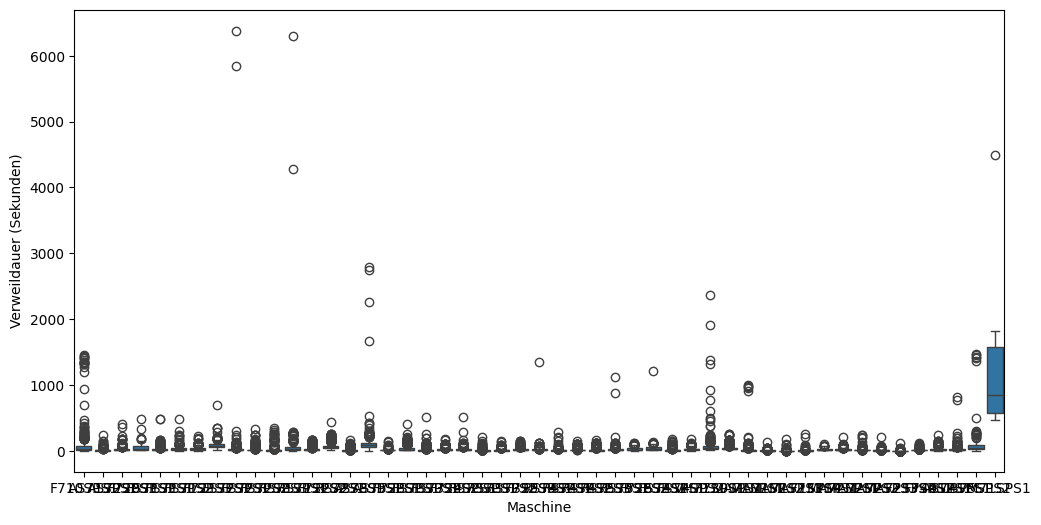

In [49]:
# Boxplot der Verweildauer für jede Maschine erstellen
sns.boxplot(x="Maschine", y="Verweildauer", data=dfCleaned)
plt.xlabel("Maschine")
plt.ylabel("Verweildauer (Sekunden)")
plt.gcf().set_size_inches((12, 6))  # Erhöht die Breite auf 10 Zoll
plt.show()

dfCleaned.to_csv('Cleaned_data.csv', index=False)

In [50]:
# Zähle nun das Aufkommen von Maschine A und Maschine B in einer Zeile (Herkunft = Start, Maschine = Ziel)
dfCounts = dfCleaned.groupby(['Herkunft', 'Maschine']).\
                    size().reset_index(name='Count')

# Ausgabe der Ergebnisse
for index, row in dfCounts.iterrows():
    print(row['Herkunft'], '->', row['Maschine'], ':', row['Count'])

# Betrachtet man die Wege, so sieht man einige seltene Ausreißer (Count sehr klein), diese Wege gehören wohl nicht zum Standardprozess

AS71SPS1 -> AS72SPS1 : 1204
AS71SPS1 -> F720SPS1 : 3
AS71SPS1 -> F740SPS1 : 6
AS71SPS1 -> FS71SPS1 : 3
AS71SPS1 -> FS71SPS2 : 5
AS72SPS1 -> F720SPS1 : 1205
AS72SPS1 -> F721SPS1 : 2
AS72SPS1 -> FS71SPS1 : 14
AS72SPS1 -> FS71SPS2 : 10
AS72SPS1 -> FS71SPS3 : 4
AS72SPS1 -> RS71SPS1 : 1
AS73SPS1 -> AS74SPS1 : 720
AS73SPS1 -> AS75SPS1 : 536
AS73SPS1 -> F723SPS1 : 4
AS73SPS1 -> FS73SPS1 : 2
AS73SPS1 -> FS73SPS2 : 1
AS73SPS1 -> RS73SPS3 : 1
AS73SPS1 -> RS74SPS1 : 1
AS74SPS1 -> F723SPS1 : 717
AS74SPS1 -> F724SPS1 : 1
AS74SPS1 -> FS73SPS1 : 6
AS74SPS1 -> RS73SPS1 : 3
AS74SPS1 -> RS73SPS2 : 1
AS75SPS1 -> F723SPS1 : 531
AS75SPS1 -> FS73SPS1 : 2
AS75SPS1 -> FS73SPS2 : 6
AS75SPS1 -> RS73SPS1 : 1
AS75SPS1 -> RS74SPS1 : 1
F710SPS1 -> AS71SPS1 : 1175
F710SPS1 -> AS72SPS1 : 2
F710SPS1 -> F720SPS1 : 1
F710SPS1 -> F740SPS1 : 18
F710SPS1 -> FS71SPS1 : 3
F710SPS1 -> FS71SPS2 : 1
F720SPS1 -> FS71SPS1 : 1212
F720SPS1 -> FS71SPS2 : 1
F720SPS1 -> FS71SPS3 : 1
F720SPS1 -> FS72SPS3 : 1
F721SPS1 -> F722SPS1 : 2
F7

In [ ]:
# Zählt die Ausgänge der einzelnen Maschinen:
dfMachineExists = dfCounts.groupby('Maschine')['Count'].sum().reset_index(name='Total_Exits')

dfMachineExists.head()

In [ ]:
# Gibt die Anzahl der Ausgänge an der Station entsprechend mit aus in der Grafik
G = pgv.AGraph(strict=False, directed=True)

G.graph_attr['rankdir'] = 'TB'
G.node_attr['shape'] = 'box'

for index, row in dfMachineExists.iterrows():
    text = row['Maschine'] + '\n(' + str(row['Total_Exits']) + ')'
    G.add_node(row['Maschine'], label=text)

# Die häufigsten Wege sollen entsprechend dünn bzw. dick ausgegeben werden.
countMin = dfCounts['Count'].min()
countMax = dfCounts['Count'].max()

# Hier die Stichstärke
thickMin = 1.0
thickMax = 5.0

for index, row in dfCounts.iterrows():
    count = row['Count']
    thick = thickMin + (thickMax-thickMin) * float(count-countMin) / float(countMax-countMin)
    G.add_edge(row['Herkunft'], row['Maschine'], label=count, penwidth=thick)

G.draw('full_graph.png', prog='dot')
Image('full_graph.png')

In [18]:
# Das Bild ist hier sehr unübersichtlich, aber es ist schon klar erkennbar wie die Wege der Paletten "normalerweise" verlaufen.
# Um das Rauschen zu entfernen könnte man sich überlegen, dass man nur die Linien ausgibt, die aus signifikant erscheinen.
# Im ersten Schritt werden alle Knoten entfernt, die kleiner 25 sind.

In [ ]:
G = pgv.AGraph(strict=False, directed=True)

G.graph_attr['rankdir'] = 'TB'
G.node_attr['shape'] = 'box'

exitsMin = dfMachineExists['Total_Exits'].min()
exitsMax = dfMachineExists['Total_Exits'].max()

# Knoten und Kanten einzeichnen, wenn mind. 50 mal die Route von Paletten
# zurückgelegt wurde (Ungewöhnliche Bewegungen entfernen)
for index, row in dfMachineExists.iterrows():
    text = row['Maschine'] + '\n(' + str(row['Total_Exits']) + ')'
    grayScale = int(float(exitsMax - row['Total_Exits']) / 
                    float(exitsMax - exitsMin) * 100.)
    fillColor = 'gray' + str(grayScale)
    fontcolor = 'black'
    if grayScale < 50:
        fontcolor = 'white'
    G.add_node(row['Maschine'], label=text, style='filled', 
               fillcolor=fillColor, fontcolor=fontcolor)

# Die häufigsten Wege sollen entsprechend dünn bzw. dick ausgegeben werden.
countMin = 25
countMax = dfCounts['Count'].max()

# Hier die Stichstärke
thickMin = 1.0
thickMax = 5.0

for index, row in dfCounts.iterrows():
    count = row['Count']
    if count >= 25:
        thick = thickMin + (thickMax-thickMin) * float(count-countMin) / \
                float(countMax-countMin)
        G.add_edge(row['Herkunft'], row['Maschine'], label=count, penwidth=thick)

G.draw('reduced_graph.png', prog='dot')
Image('reduced_graph.png')

In [20]:
# Aus dieser Grafik ist schon ganz klar der Standardprozess erkennbar. Die farbliche Gestaltung der Maschinen-Boxen hilft auch
# nochmal zu verstehen welche Maschinen außen vor sind (weiße Box) und nicht zum Standardprozess gehören oder evtl. neu sind?! 
# Und welche Maschinen zum Beispiel äquivalent zueinander sind (graue Boxen)

# Der nächste Schritt wäre die Identifikation von Bottlenecks. Hier kommt jezt die Verweildauer ins Spiel.

In [21]:
# Summe der Verweildauer pro Maschine berechnen
dfSumVerweildauer = dfCleaned.groupby('Maschine')['Verweildauer'].sum().reset_index(name='Summe_Verweildauer')

# Zusammenführen der Summe der Verweildauer mit den Total_Exits
dfVerweildauer = pd.merge(dfSumVerweildauer, dfMachineExists, on='Maschine')

# Berechnen der durchschnittlichen Verweildauer
dfVerweildauer['Durchschnitt_Verweildauer'] = dfVerweildauer['Summe_Verweildauer'] / dfVerweildauer['Total_Exits']

dfVerweildauer.head()

,Maschine,Summe_Verweildauer,Total_Exits,Durchschnitt_Verweildauer
0,AS71SPS1,14847.733333,1202,12.352524
1,AS72SPS1,26322.533333,1217,21.629033
2,AS73SPS1,121899.866667,1264,96.439768
3,AS74SPS1,18884.750000,727,25.976272
4,AS75SPS1,6995.016667,542,12.905935


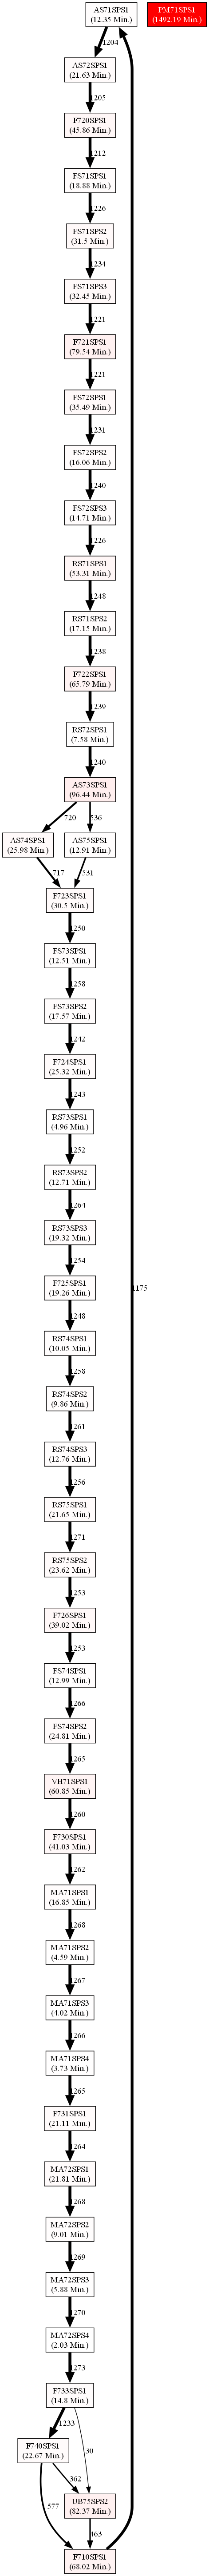

In [22]:
# Initialisierung des Graphen
G = pgv.AGraph(strict=False, directed=True)

G.graph_attr['rankdir'] = 'TB'
G.node_attr['shape'] = 'box'

# Berechnung der minimalen und maximalen Verweildauer
verweildauerMin = dfVerweildauer['Durchschnitt_Verweildauer'].min()
verweildauerMax = dfVerweildauer['Durchschnitt_Verweildauer'].max()

def calculate_color(value, min_value, max_value):
    if max_value == 0:
        return f'#FFFFFF'
    # Anpassung, so dass höhere Werte dunkleres Rot ergeben und niedrigere Werte heller (weiß) sind
    ratio = (value - min_value) / (max_value - min_value)
    # Rot bleibt konstant hoch für hohe Werte, Grün und Blau werden reduziert, um Weiß bis Rot zu erreichen
    red = 255
    green = blue = int(255 * (1 - ratio))  # Reduzierung von Grün und Blau für höhere Werte
    hex_color = f'#{red:02x}{green:02x}{blue:02x}'
    return hex_color

for index, row in dfVerweildauer.iterrows():
    text = row['Maschine'] + '\n(' + str(round(row['Durchschnitt_Verweildauer'],2)) + ' Min.)'
    color = calculate_color(row['Durchschnitt_Verweildauer'], verweildauerMin, verweildauerMax)
    fontcolor = 'black' if row['Durchschnitt_Verweildauer'] < (verweildauerMax - verweildauerMin) / 2 else 'white'
    G.add_node(row['Maschine'], label=text, style='filled', fillcolor=color, fontcolor=fontcolor)

# Hinzufügen der Kanten mit Dickenanpassung basierend auf der Anzahl der Wege
for index, row in dfCounts.iterrows():
    count = row['Count']
    if count >= 25:
        thick = thickMin + (thickMax - thickMin) * float(count - countMin) / float(countMax - countMin)
        G.add_edge(row['Herkunft'], row['Maschine'], label=str(count), penwidth=thick)

# Zeichnen des Graphen
G.draw('bottleneck_graph.png', prog='dot')
Image('bottleneck_graph.png')

In [23]:
df_sorted_by_time = dfCleaned.copy()
df_sorted_by_time['Zeitpunkt'] = pd.to_datetime(df_sorted_by_time['Zeitpunkt'])
df_sorted_by_time = df_sorted_by_time.sort_values(by=['Zeitpunkt'], ascending=True).reset_index(drop=True)
df_sorted_by_time

df_sorted_by_time.to_csv('data_ready_for_LSTM.csv', index=False)
df_sorted_by_time

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage
0,2020-11-30 00:07:36,Montage BAU 2 1.OG,RS72SPS1,200060,F722SPS1,6.083333,True,2,OG
1,2020-11-30 00:14:42,Montage BAU 2 1.OG,RS72SPS1,201078,F722SPS1,2.716667,True,2,OG
2,2020-11-30 00:29:19,Montage BAU 2 1.OG,RS71SPS1,200465,FS72SPS2,28.183333,False,2,OG
3,2020-11-30 00:33:46,Montage BAU 3 UG,F740SPS1,201442,F733SPS1,26.050000,False,3,UG
4,2020-11-30 00:36:30,Montage BAU 2 1.OG,RS72SPS1,201181,F722SPS1,2.383333,True,2,OG
...,...,...,...,...,...,...,...,...,...
58307,2020-12-05 15:39:42,Montage BAU 2 1.OG,FS72SPS2,200005,FS72SPS1,96.816667,False,2,OG
58308,2020-12-05 15:43:55,Montage BAU 2 1.OG,FS72SPS3,200005,FS72SPS2,4.216667,False,2,OG
58309,2020-12-05 16:53:40,Montage BAU 2 1.OG,AS75SPS1,201157,AS73SPS1,126.383333,False,2,OG
58310,2020-12-05 22:19:02,Montage BAU 3 UG,F723SPS1,201701,AS75SPS1,401.366667,True,3,UG
